In [1]:
from qiskit.circuit.library import UnitaryGate
import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from collections import Counter  
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt  
#from controlled_gates import append_conditional_gates

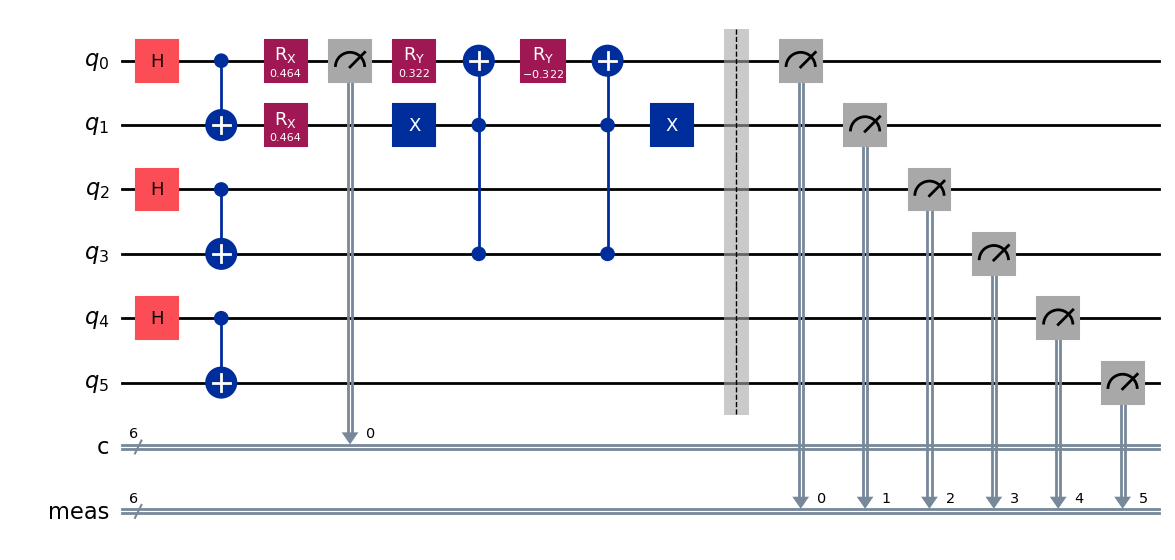

In [15]:


#adjacency_matrix = np.loadtxt("adjacency_matrix.csv", delimiter=",")

adjacency_matrix = [[1.00,0.10,0.13],
                    [0.20,1.00,0.50],
                    [0.17,0.30,1.00]]
# each a_ij is p(i_failing|j_failing)

# Define the parameter p
p = adjacency_matrix[0][1] #this is not the correct p, but anyways

rotation_angle = np.arcsin(1-2*p)/2

num_qubits = 6
qr = QuantumRegister(num_qubits,'q')
qc = QuantumCircuit(num_qubits,num_qubits)

# Entangle qubits in pairs
pairs = [(0, 1), (2, 3), (4, 5)]  # Define the pairs to entangle
for q1, q2 in pairs:
    qc.h(q1)  # Apply Hadamard gate to create superposition
    qc.cx(q1, q2)  # Apply CNOT gate to create entanglement

# Make a rotation to the pair of entangled qubits
qc.rx(rotation_angle,0)
qc.rx(rotation_angle,1)

# Measure 

qc.measure(0,0)

theta2 = 2*np.arcsin(np.sqrt(p))

#controlled rotation on qubit 0, using 
# controls of copy of in qubit 1 and the 
# in the qubit 3. 

#controlled rotations are weird :()
qc.x(1)
qc.mcry(theta2,[1,3], 0)
qc.x(1)

qc.measure_all()

qc.draw("mpl")



  Using cached pylatexenc-2.10-py3-none-any.whl
